In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../') #adding Coral Home, temp hack

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and Visualize Dataset
First, we load the dataset and associated bounding box objects and labels.
Note that in some cases, the resulting images from the query will be incorrectly labeled. THis is because the ground truth also comes from a crodsourced setting where relations in the image are described, and therefore prone to error.

**Make sure to run `unzip tutorial_data` before running this cell!**

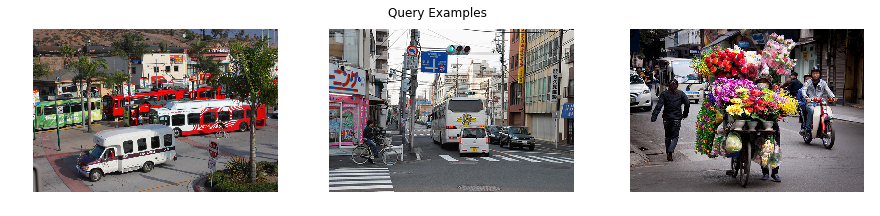

In [15]:
from data_loader import DataLoader
loader = DataLoader()

loader.show_examples(annotated=False, label=1)

## Generate Primitives
Since we cannot check relations in the images directly by writing labeling functions over the primitives, we first extract a set of  "primitives" from the images that are easily interpretable.

In this case, we use information about the objects in the data such as their labels, their positions and their size.  We show how we develop simple primitives that are based on the labels of the different objects and include the more complex primitives in `primitive_helpers.py`.

#### Membership-based Primitives
Check whether certain objects appear in the images

In [16]:
def has_bike(object_names):
    if ('cycle' in object_names) or ('bike' in object_names) or ('bicycle' in object_names):
        return 1
    else:
        return 0

In [17]:
def has_human(object_names):
    if (('person' in object_names) or ('woman' in object_names) or ('man' in object_names)) and (('bicycle' in object_names) or 'bicycles' in object_names):
        return 1
    else:
        return 0

In [18]:
def has_road(object_names):
    if ('road' in object_names) or ('street' in object_names) or ('concrete' in object_names):
        return 1
    else:
        return 0

In [19]:
def has_cars(object_names):
    if ('car' in object_names) or ('cars' in object_names) or ('bus' in object_names) or ('buses' in object_names) or ('truck' in object_names) or ('trucks' in object_names):
        return 1
    else:
        return 0

#### Object Relationship Based Primitives
These look at the relation among the bikes and the people in the images. These include checking the relative:
* number of bikes vs people
* position of bikes vs people
* size of bikes vs people

Code for the development of these primitives is included in the file `primitive_helpers.py`.

In [20]:
from primitive_helpers import *
def create_primitives(loader):
    m = 7
    primitive_mtx = np.zeros((loader.train_num,m))

    for i in xrange(loader.train_num):
        primitive_mtx[i,0] = has_human(loader.train_object_names[i])
        primitive_mtx[i,1] = has_road(loader.train_object_names[i])
        primitive_mtx[i,2] = has_cars(loader.train_object_names[i])
        primitive_mtx[i,3] = has_bike(loader.train_object_names[i])

        primitive_mtx[i,4] = bike_human_distance(loader.train_object_names[i], 
                                                 loader.train_object_x[i], 
                                                 loader.train_object_y[i])

        area = np.multiply(loader.train_object_height[i], loader.train_object_width[i])
        primitive_mtx[i,5] = bike_human_size(loader.train_object_names[i], area)
        primitive_mtx[i,6] = bike_human_nums(loader.train_object_names[i])
        
    P = PrimitiveObject()
    P.save_primitive_matrix(primitive_mtx)
    return P

**Assign and Name Primitives**
We assign the primitives and name them according to the variables we will use to refer to them in the heuristic functions we develop next. 

For example, `primitive_mtx[i,0]` is referred to as `has_human`.

In [8]:
P = create_primitives(loader)
primitive_names = ['has_human', 'has_road', 'has_cars', 'has_bike', 
                   'bike_human_distance', 'bike_human_size', 'bike_human_num']

## Heuristic Functions
We now develop heuristic functions that take different primitives in as inputs and apply a label based on the value of those primitives. 

In [21]:
def LF_street(has_human, has_road):
    if has_human >= 1: 
        if has_road >= 1:
            return 1
        else:
            return -1
    return 0

def LF_vehicles(has_human, has_cars):
    if has_human >= 1: 
        if has_cars >= 1:
            return 1
        else:
            return -1
    return 0

def LF_distance(has_human, has_bike, bike_human_distance):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_distance <= np.sqrt(8):
                return 1
            else:
                return 0
    else:
        return -1
    
def LF_size(has_human, has_bike, bike_human_size):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_size <= 1000:
                return -1
            else:
                return 0
    else:
        return -1
    
    
def LF_number(has_human, has_bike, bike_human_num):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_num >= 2:
                return 1
            if bike_human_num >= 1:
                return 0
            if bike_human_num >= 0:
                return 1
    else:
        return -1

**Assign Heuristic Functions**

We create a list of the functions we used in `L_names` and apply *static analysis* to the heuristic functions to see how the functions share primitives. 

`L_deps` prints the index of the primitives each of the heuristic functions takes in as input.

In [22]:
L_names = [LF_street,LF_vehicles,LF_distance,LF_size,LF_number]
# from coral.static_analysis.dependency_learning import find_dependencies
# L_deps = find_dependencies(L_names, primitive_names)
# print L_deps

In [25]:
P.primitive_mtx.shape

(903, 7)

In [23]:
L = np.zeros((len(L_names),loader.train_num))
for i in xrange(loader.train_num):
    for j in xrange(5):
        vocab_elems = P.primitive_mtx[i,L_deps[j]]
        L[j,i] = L_names[j](*vocab_elems)

NameError: name 'L_deps' is not defined

**Calculate and Show Accuracy and Coverage of Heuristic Functions**

In [12]:
total = float(loader.train_num)

stats_table = np.zeros((5,2))
for i in range(5):
    stats_table[i,1] = np.sum(L[i,:] == loader.train_ground)/float(np.sum(L[i,:] != 0))
    stats_table[i,0] = np.sum(L[i,:] != 0)/total

In [13]:
import pandas as pd
stats_table = pd.DataFrame(stats_table, index = [i.__name__ for i in L_names], columns = ["Coverage", "Accuracy"])
stats_table

,Coverage,Accuracy
LF_street,0.444075,0.663342
LF_vehicles,0.444075,0.680798
LF_distance,0.609081,0.747273
LF_size,0.573643,0.770270
LF_number,0.712071,0.690513


## Generate Training Set

In [16]:
from coral.learning import CoralModel
from coral.learning import CoralDependencySelector
from numbskull.udf import *

from coral.static_analysis.dependency_learning import discretize_primitives

from scipy import sparse
L_train = sparse.csr_matrix(L.T)

**Majority Vote**

To get a sense of how well our heuristic functions are, we calcuate the accuracy of the training set labels if we took the majority vote label for each data point.

In [17]:
mv_labels = np.sign(np.sum(L.T,1))
print 'Coverage of Majority Vote on Train Set: ', np.sum(mv_labels != 0)/float(loader.train_num)
print 'Accuracy of Majority Vote on Train Set: ', np.sum(mv_labels == loader.train_ground)/float(loader.train_num)

Coverage of Majority Vote on Train Set:  0.906976744186
Accuracy of Majority Vote on Train Set:  0.674418604651


**Independent Heuristic Functions**
To demonstrate why incorporating dependencies is beneficial, we first assume that the heuristic functions are independent.

In [31]:
from coral.learning.indep_learning import IndepModel
indep_model = IndepModel()
indep_model.train(L.T, rate=5e-4, mu=1e-2, verbose=False)

marginals = indep_model.marginals(sparse.csr_matrix(L.T))
labels = 2 * (marginals > 0.6) - 1
print 'Accuracy of Coral on Train Set:', np.mean(labels == loader.train_ground)

Accuracy of Coral on Train Set: 0.700996677741


**Coral with Static Analysis**

Now, we model the accuracy and dependencies among the different heuristic functions and assign training set labels accordingly. 

Note that we have to discretize the primitives (that is, make sure they have integer values) since our underlying inference system requires discrete labels. We perform this discretization via static analysis as well.

In [16]:
code = discretize_primitives(L_names)
P.discrete_primitive_mtx = np.zeros((loader.train_num,len(primitive_names)))
for i in range(loader.train_num):
    for j in range(len(code)):
        exec(code[j])

In [17]:
coral_model = CoralModel()

P.discrete_primitive_mtx = P.discrete_primitive_mtx.astype(int)
cardinality = []
for v_idx in xrange(P.num_primitives):
    cardinality.append(int(np.max(P.discrete_primitive_mtx[:,v_idx])+1))

In [18]:
coral_model.train(P.discrete_primitive_mtx, cardinality, L_deps, VG_UDF_OFFSET, epochs = 100)
marginals = coral_model.marginals(P.discrete_primitive_mtx, cardinality, L_deps, VG_UDF_OFFSET, epochs=1000)
labels = 2 * (marginals > 0.6) - 1
print 'Accuracy of Coral on Train Set:', np.mean(labels == loader.train_ground)

Accuracy of Coral on Train Set: 0.755260243632


**Coral with Static and Statistical Analysis**

Now, we additionally model the correlations among the different primitives we use and check whether it improves the overall accuracy of the training set labels.

In [19]:
ds = CoralDependencySelector()
coral_model = CoralModel()

In [20]:
thresh=0.15
reg = 0.

deps = ds.select(P.discrete_primitive_mtx, cardinality, L_deps, "VG", threshold=thresh)
coral_model.train(P.discrete_primitive_mtx, cardinality, L_deps, VG_UDF_OFFSET, deps=list(deps), epochs=100, burn_in=0, reg_type=1, reg_param=reg)
marginals = coral_model.marginals(P.discrete_primitive_mtx, cardinality, L_deps, VG_UDF_OFFSET, deps=list(deps), epochs=1000)
labels = 2 * (marginals > 0.6) - 1

print 'Dependencies: ', deps
print 'Accuracy of Coral with Primitive Dependencies on Train Set:', np.mean(labels == loader.train_ground)

Dependencies:  set([(4, 5), (3, 4), (0, 5), (3, 6), (3, 5)])
Accuracy of Coral with Primitive Dependencies on Train Set: 0.755260243632
